# Proyecto para la pedicción de elegibilidad de un paciente para exámenes de cancer.

Integrantes del grupo:

* Carlos E. Ramirez Martinez (201921729)
* Nicolás Carvajal Chaves (201922019)
* Miguel Angel Ramos Hurtado (201814917)

En este archivo encontrará el proceso completo que se realizó para poder dar cumplimiento a los objetivos de negocio. Este proceso está soportado directamente con codigo Python y su correspondiente expliación.

### 1. Instalación e importanción de librerías.


In [1]:
# Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions

In [2]:
# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect
!pip install pandas-profiling==2.7.1

  Attempting uninstall: visions
    Found existing installation: visions 0.7.4
    Uninstalling visions-0.7.4:
      Successfully uninstalled visions-0.7.4
  Attempting uninstall: pandas-profiling
    Found existing installation: pandas-profiling 3.1.0
    Uninstalling pandas-profiling-3.1.0:
      Successfully uninstalled pandas-profiling-3.1.0


In [3]:
# librería Natural Language Toolkit, usada para trabajar con textos 
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cupi2\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [4]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
# ¿Cuales son esas palabras vacías?

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cupi2\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [5]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
# ¿Qué es el lema de una palabra? ¿Qué tan dificil puede ser obtenerlo, piensa en el caso en que tuvieras que escribir la función que realiza esta tarea?
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Cupi2\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [6]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata

import contractions
import inflect

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin


import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

### 2. Perfilamiento y entendimiento de los datos



#### Lectura de los datos.

Inicialmente, se realizará una lectura superficial del conjunto de datos.

In [7]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('clinical_trials_on_cancer_data_clasificacion.csv', sep=',', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data_t=data


In [8]:
data_t

,label,study_and_condition
0,__label__0,study interventions are Saracatinib . recurren...
1,__label__1,study interventions are Stem cell transplantat...
2,__label__0,study interventions are Lenograstim . recurren...
3,__label__0,study interventions are Doxorubicin . stage ii...
4,__label__1,study interventions are Poly I-C . prostate ca...
...,...,...
11995,__label__0,study interventions are Prednisolone hemisucci...
11996,__label__0,study interventions are Bevacizumab . recurren...
11997,__label__1,"study interventions are Antibodies, Monoclonal..."
11998,__label__0,study interventions are Vorinostat . colorecta...


De esta lectura inicial, ya se puede extraer lo que será la variable objetivo "Labels", además de observar que la columna "study and condition" debera ser procesada anrtes de la construcción de los modelos.

#### Entendimiento de los Datos

Para entender los mensajes, se realizan 'estadísticas descriptivas' para poder obtener un análisis de los textos, se calcula la palabra de longitud mínima y máxima ademas de la moda.

In [5]:
textos = data_t.copy()
textos['Conteo'] = [len(x) for x in textos['study_and_condition']]
words = {}
for x in textos['study_and_condition']:
    if (x in words.keys()):
        words[x] += 1
    else:
        words[x] = 0
max_word = ('',0)
for x in words.keys():
    if (words[x] > max_word[1]):
        max_word = (x,words[x])
print(max_word)
textos['Moda'] = max_word[0]
textos['Max'] = 1
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['study_and_condition']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(textos)

('study interventions are Antibodies . lymphoma diagnosis and not specified', 1)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
textos

,label,study_and_condition,Conteo,Moda,Max,Min
0,__label__0,study interventions are Saracatinib . recurren...,250,study interventions are Antibodies . lymphoma ...,15,1
1,__label__1,study interventions are Stem cell transplantat...,224,study interventions are Antibodies . lymphoma ...,15,1
2,__label__0,study interventions are Lenograstim . recurren...,229,study interventions are Antibodies . lymphoma ...,13,1
3,__label__0,study interventions are Doxorubicin . stage ii...,268,study interventions are Antibodies . lymphoma ...,13,1
4,__label__1,study interventions are Poly I-C . prostate ca...,232,study interventions are Antibodies . lymphoma ...,15,1
...,...,...,...,...,...,...
11995,__label__0,study interventions are Prednisolone hemisucci...,146,study interventions are Antibodies . lymphoma ...,16,1
11996,__label__0,study interventions are Bevacizumab . recurren...,155,study interventions are Antibodies . lymphoma ...,13,1
11997,__label__1,"study interventions are Antibodies, Monoclonal...",136,study interventions are Antibodies . lymphoma ...,16,1
11998,__label__0,study interventions are Vorinostat . colorecta...,157,study interventions are Antibodies . lymphoma ...,13,1


### 3. Preparación de datos

El proceso de preparación de los datos se dará en tres (3) etapas.

#### **3.1 Limpieza de los datos**
En esta primera parte, se quieren definir las funciones para limpiar los textos. Primero, se desea uniformidad, por lo que se pasarán todos los caracteres a minúscula. Seguidamente, se eliminan los caracteres no ASCII, los signos de puntuación y las "stopwords", que son palabras que son frecuentemente usadas como artículos, conjunciones, etc., pero que no son significativas para el modelo. Finalmente, se remplazan los números por sus respectivas representaciones en palabras.

In [11]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        if word != word.lower():
            new_words.append(word.lower())
        else:
            new_words.append(word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    sw = set(stopwords.words('english'))
    
    new_words = []
    for word in words:
        if word not in sw:
            new_words.append(word)
    return new_words
    

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

#### **3.2 Tokenización**
En esta etapa se dividiran las frases y oraciones en palabras individuales, en este proceso se aplicarán las funciones definidas en la etapa de limpieza.

In [12]:
data_t['study_and_condition'] = data_t['study_and_condition'].apply(contractions.fix) #Aplica la corrección de las contracciones

In [13]:
data_t['words'] = data_t['study_and_condition'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
data_t.head()

,label,study_and_condition,words
0,__label__0,study interventions are Saracatinib . recurren...,"[study, interventions, saracatinib, recurrent,..."
1,__label__1,study interventions are Stem cell transplantat...,"[study, interventions, stem, cell, transplanta..."
2,__label__0,study interventions are Lenograstim . recurren...,"[study, interventions, lenograstim, recurrent,..."
3,__label__0,study interventions are Doxorubicin . stage ii...,"[study, interventions, doxorubicin, stage, iii..."
4,__label__1,study interventions are Poly I-C . prostate ca...,"[study, interventions, poly, ic, prostate, can..."


Como se obseva, se agregó la columna words que contiene las palabras que se encuentran en el texto separadas individualmente y limpias.

#### **3.3. Normalización**
A pesar de ya contar con los conjuntos de palabras limpios, falta algunos detalles por cubrir. Primero, existen varias palabras con prefijos y sufijos, las cuales tienen en escencia, un mismo significado. Segundo, hay palabras con mismo significado, pero que están conjugadas respecto al contexto en el que se escriben. Para las palabras del primer caso se aplica una steming y para las segundas una lemmatización.

In [14]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemer = LancasterStemmer()
    stems = []
    
    for i in words:
        stems.append(stemer.stem(i))
    
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    
    for i in words:
        lemmas.append(lemmatizer.lemmatize(i))
    
    return lemmas
        

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

data_t['words'] = data_t['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
data_t.head()

,label,study_and_condition,words
0,__label__0,study interventions are Saracatinib . recurren...,"[study, interv, saracatinib, recur, verruc, ca..."
1,__label__1,study interventions are Stem cell transplantat...,"[study, interv, stem, cel, transpl, hodgkin, l..."
2,__label__0,study interventions are Lenograstim . recurren...,"[study, interv, lenograstim, recur, adult, dif..."
3,__label__0,study interventions are Doxorubicin . stage ii...,"[study, interv, doxorubicin, stag, ii, diffus,..."
4,__label__1,study interventions are Poly I-C . prostate ca...,"[study, interv, poly, ic, prost, cant, diagnos..."


##### **3.4 Selección de campos**

Primero, se separa la variable predictora y los textos que se van a utilizar.

In [15]:
data_t['words'] = data_t['words'].apply(lambda x: ' '.join(map(str, x)))
data_t

,label,study_and_condition,words
0,__label__0,study interventions are Saracatinib . recurren...,study interv saracatinib recur verruc carcinom...
1,__label__1,study interventions are Stem cell transplantat...,study interv stem cel transpl hodgkin lymphom ...
2,__label__0,study interventions are Lenograstim . recurren...,study interv lenograstim recur adult diffus mi...
3,__label__0,study interventions are Doxorubicin . stage ii...,study interv doxorubicin stag ii diffus larg c...
4,__label__1,study interventions are Poly I-C . prostate ca...,study interv poly ic prost cant diagnos unreso...
...,...,...,...
11995,__label__0,study interventions are Prednisolone hemisucci...,study interv prednisolon hemisuccin recur chil...
11996,__label__0,study interventions are Bevacizumab . recurren...,study interv bevacizumab recur rect cant diagn...
11997,__label__1,"study interventions are Antibodies, Monoclonal...",study interv antibody monoclon recur lymphobla...
11998,__label__0,study interventions are Vorinostat . colorecta...,study interv vorinost colorect cant diagnos pa...


In [16]:
x_data, y_data = data_t['words'],data_t['label']
y_data = y_data.apply(lambda x: int(x[9]))
y_data

0        0
1        1
2        0
3        0
4        1
        ..
11995    0
11996    0
11997    1
11998    0
11999    0
Name: label, Length: 12000, dtype: int64

Para poder contruir los modelos se debe convertir las palabras a un esquema numérico y comparable. Para ello, existen varias opciones como crear una matriz por frecuecia de la palabra en el documento, sin embargo se decidió utilizar TfidfVectorizer, ya que este tiene en cuenta la frecuencia de términos (TF) y la frecuencia inversa de los datos (IDF), en términos generales, para cada pareja palabra-documento, este algoritmo registra la multipliación de los dos factores mencionados anteriormente.

In [17]:
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(x_data)

feature_names = tf_idf.get_feature_names()
dense = X_tf_idf.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

C:\Users\Cupi2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
df.to_csv(r".\processed_data.csv")
df.head()

,01,01910na,025,05,09,0three_two9,0two_two009,10deazaaminopterin,11,12,...,zoledron,zoledronate,zoledronic,zolmitrib,zolmitriptan,zomet,zometa,zon,zone,zubrod
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#Lectura de datos provisional
df=pd.read_csv('processed_data.csv', sep=',', encoding = 'utf-8',index_col = 0)

In [20]:
df.head()

,01,01910na,025,05,09,0three_two9,0two_two009,10deazaaminopterin,11,12,...,zoledron,zoledronate,zoledronic,zolmitrib,zolmitriptan,zomet,zometa,zon,zone,zubrod
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
y_data = data_t['label']
y_data = y_data.apply(lambda x: int(x[9]))
y_data.value_counts()

0    6000
1    6000
Name: label, dtype: int64

### 4. Construcción de los Modelos

#### 4.1 Modelo 1: Árbol de Desición.

In [22]:
# Dividir los datos en entrenamiento y test
X_train_SMOTE, X_test, Y_train_SMOTE, Y_test = train_test_split(df, y_data, test_size = 0.2, random_state = 0)

En el caso de los árboles de decisión los hiperparámetros a ajustar son:

- criterion : {“gini”, “entropy”}, predeterminado = "gini".
La función para medir la calidad de una división.
- max_depth: int, predeterminado=None.
La profundidad máxima del árbol.

- min_samples_split : int or float, predeterminado=2.
El número mínimo de muestras necesarias para dividir un nodo interno.

Se usó le técnica de K-Fold Cross Validation para encontrar los mejores hiperparámetros: 

In [23]:
# Se fija el número de particiones. Se usará K = 10.
particiones = KFold(n_splits = 10, shuffle = True, random_state = 0)

# Se establece el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [4, 6, 8, 10, 20], 'min_samples_split': [2, 3, 4, 5]}

# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol_inicial = DecisionTreeClassifier(random_state = 0)

# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol_inicial, param_grid, cv = particiones, n_jobs = -1)

# Ajuste del modelo
mejor_modelo.fit(X_train_SMOTE, Y_train_SMOTE)

# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
best = mejor_modelo.best_params_

In [24]:
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}

Una vez obtenidos los mejores hiperparámetros, se procede con la construcción del modelo 

In [25]:
# Obtener el mejor modelo.
arbol = mejor_modelo.best_estimator_

In [26]:
# Probemos ahora este modelo sobre test.
y_pred_train = arbol.predict(X_train_SMOTE)
y_pred_test = arbol.predict(X_test)
entrenamiento_score = accuracy_score(Y_train_SMOTE, y_pred_train)
test_score = accuracy_score(Y_test, y_pred_test)
print('Exactitud sobre entrenamiento: %.2f' % entrenamiento_score)
print('Exactitud sobre test: %.2f' % test_score)

Exactitud sobre entrenamiento: 0.80
Exactitud sobre test: 0.72


Datos de entranamiento
              precision    recall  f1-score   support

           0       0.73      0.94      0.82      4772
           1       0.92      0.66      0.77      4828

    accuracy                           0.80      9600
   macro avg       0.83      0.80      0.79      9600
weighted avg       0.83      0.80      0.79      9600



C:\Users\Cupi2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


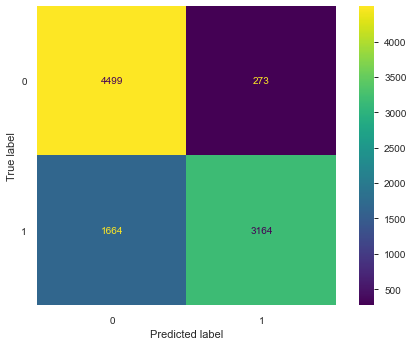

In [27]:
# Se imprime el informe de rendimiento
print("Datos de entranamiento")
print(classification_report(Y_train_SMOTE, y_pred_train))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(arbol, X_train_SMOTE, Y_train_SMOTE)  
plt.show()  

Datos de prueba
              precision    recall  f1-score   support

           0       0.68      0.85      0.76      1228
           1       0.78      0.59      0.67      1172

    accuracy                           0.72      2400
   macro avg       0.73      0.72      0.71      2400
weighted avg       0.73      0.72      0.71      2400



C:\Users\Cupi2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


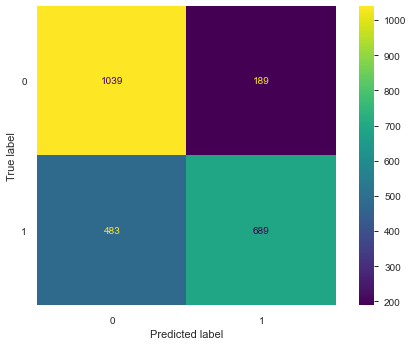

In [28]:
# Se imprime el informe de rendimiento
print("Datos de prueba")
print(classification_report(Y_test, y_pred_test))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(arbol, X_test, Y_test)  
plt.show()  

In [29]:
# Obtener la importancia de las variables. Mientras mayor el coeficiente, más la importancia.
importancia_atributo = pd.DataFrame(data={"Atributo": X_train_SMOTE.columns, "Importancia": arbol.feature_importances_})
importancia_atributo = importancia_atributo.sort_values(by = 'Importancia', ascending = False).reset_index(drop = True)
importancia_atributo

,Atributo,Importancia
0,history,0.066060
1,must,0.059306
2,tre,0.047784
3,paty,0.042854
4,doc,0.029930
...,...,...
10989,fee,0.000000
10990,feed,0.000000
10991,feeding,0.000000
10992,feel,0.000000


In [30]:
# Se calcula la probabilidad de que un dato cualquiera sea puesto en cada categoría
print(arbol.predict_proba(X_test.iloc[[2]]))

[[0.50790151 0.49209849]]


#### 4.2 Modelo 2: Regresión logística

In [31]:
lr_inicial = LogisticRegression()

C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

parameters = dict(C=C,penalty=penalty)

mejor_modelo_lr = GridSearchCV(lr_inicial, parameters, n_jobs = -1)
mejor_modelo_lr.fit(X_train_SMOTE, Y_train_SMOTE)

mejor_modelo_lr.best_params_

C:\Users\Cupi2\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Cupi2\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Cupi2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Cupi2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
V

{'C': 7.9060432109076855, 'penalty': 'l2'}

In [32]:
lr = mejor_modelo_lr.best_estimator_

In [33]:
# Probemos ahora este modelo sobre test.
y_pred_train = lr.predict(X_train_SMOTE)
y_pred_test = lr.predict(X_test)
entrenamiento_score = accuracy_score(Y_train_SMOTE, y_pred_train)
test_score = accuracy_score(Y_test, y_pred_test)
print('Exactitud sobre entrenamiento: %.2f' % entrenamiento_score)
print('Exactitud sobre test: %.2f' % test_score)

Exactitud sobre entrenamiento: 0.92
Exactitud sobre test: 0.80


Datos de entranamiento
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4772
           1       0.91      0.92      0.92      4828

    accuracy                           0.92      9600
   macro avg       0.92      0.92      0.92      9600
weighted avg       0.92      0.92      0.92      9600



C:\Users\Cupi2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


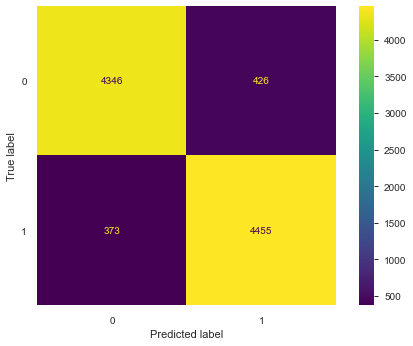

In [34]:
# Se imprime el informe de rendimiento
print("Datos de entranamiento")
print(classification_report(Y_train_SMOTE, y_pred_train))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(lr, X_train_SMOTE, Y_train_SMOTE)  
plt.show()  

Datos de prueba
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1228
           1       0.78      0.81      0.79      1172

    accuracy                           0.80      2400
   macro avg       0.80      0.80      0.80      2400
weighted avg       0.80      0.80      0.80      2400



C:\Users\Cupi2\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


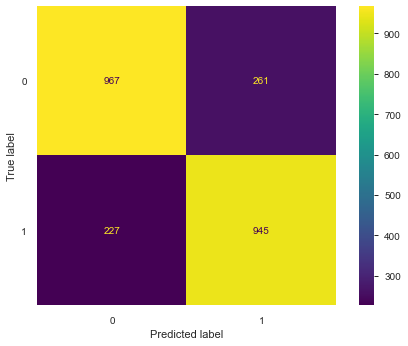

In [35]:
# Se imprime el informe de rendimiento
print("Datos de prueba")
print(classification_report(Y_test, y_pred_test))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(lr, X_test, Y_test)  
plt.show()  

In [36]:
# Se calcula la probabilidad de que un dato cualquiera sea puesto en cada categoría
print(lr.predict_proba(X_test.iloc[[2]]))

[[0.74550327 0.25449673]]


#### 4.3 Modelo 3: KNN

In [104]:
# Lista de Hiperparámetros a afinar
n_neighbors = list(range(1,10))
n_odd_neighbors = list(filter(lambda x: (x % 2 != 0), n_neighbors))
p=[1,2] #Función de distancia 1: manhattan, 2: euclidean, otro valor: minkowski

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_odd_neighbors, p=p)

#Create new KNN object
knn_inicial = KNeighborsClassifier()

#Use GridSearch
mejor_modelo_knn = GridSearchCV(knn_inicial, hyperparameters, cv=10, n_jobs = -1)

#Fit the model
mejor_modelo_knn.fit(X_train_SMOTE, Y_train_SMOTE)

mejor_modelo_knn.best_params_

{'n_neighbors': 3, 'p': 2}

In [105]:
knn = mejor_modelo_knn.best_estimator_

In [106]:
# Probemos ahora este modelo sobre test.
y_pred_train = knn.predict(X_train_SMOTE)
y_pred_test = knn.predict(X_test)
entrenamiento_score = accuracy_score(Y_train_SMOTE, y_pred_train)
test_score = accuracy_score(Y_test, y_pred_test)
print('Exactitud sobre entrenamiento: %.2f' % entrenamiento_score)
print('Exactitud sobre test: %.2f' % test_score)

Exactitud sobre entrenamiento: 0.87
Exactitud sobre test: 0.75


Datos de entranamiento
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      4772
           1       0.89      0.86      0.87      4828

    accuracy                           0.87      9600
   macro avg       0.87      0.87      0.87      9600
weighted avg       0.87      0.87      0.87      9600



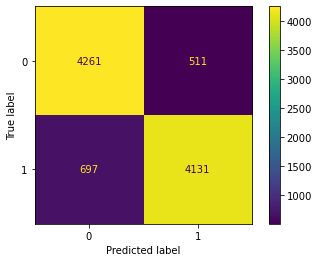

In [107]:
# Se imprime el informe de rendimiento
print("Datos de entranamiento")
print(classification_report(Y_train_SMOTE, y_pred_train))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(knn, X_train_SMOTE, Y_train_SMOTE)  
plt.show()  

Datos de prueba
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1228
           1       0.76      0.73      0.74      1172

    accuracy                           0.75      2400
   macro avg       0.75      0.75      0.75      2400
weighted avg       0.75      0.75      0.75      2400



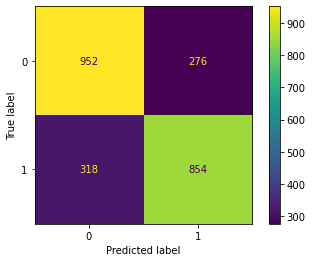

In [108]:
# Se imprime el informe de rendimiento
print("Datos de prueba")
print(classification_report(Y_test, y_pred_test))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(knn, X_test, Y_test)  
plt.show()  

In [110]:
# Se calcula la probabilidad de que un dato cualquiera sea puesto en cada categoría
print(knn.predict_proba(X_test.iloc[[2]]))

[[0.66666667 0.33333333]]


### 5. Conclusiones finales

Una vez construidos los tres diferentes modelos, se observa a partir de sus respectivas métricas,el modelo que mejor cumple el objetivo de negocio: clasificar a los pacientes que son elegibles para ensayos clínicos de cancer; es el de regresión logistica, con una puntuación F1 promedio de 0.80, muestra ser un modelo adecuado y confiable para la tarea planteada. Detallando un poco más acerca de su comportamiento, se observa que para los elegibles (0), el recall es menor a la precisión, esto indica que hay un mayor número de falsos negativos para esta categoría. En consecuencia, se observa el comportamiento opuesto para los elegibles.